# Diabetes regression training vs validation loss

In [1]:
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

dtype = torch.double

In [2]:
d = load_diabetes()
len(d.data)

442

In [3]:
df = pd.DataFrame(d.data, columns=d.feature_names)
df['disease'] = d.target # "quantitative measure of disease progression one year after baseline"
df.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0


## Split data into train, validation sets

We'll use "test" as shorthand for "validation" but technically they are not the same.

In [4]:
n = len(df)
n_test = int(n*0.20)
n_train = n - n_test
df = df.sample(frac=1) # shuffle data
X = df.drop('disease',axis=1).values
y = df['disease'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test)

In [5]:
m = np.mean(X_train,axis=0)
std = np.std(X_train,axis=0)
X_train = (X_train-m)/std
X_test = (X_test-m)/std       # use training data only when prepping test sets

## Baseline with random forest

In [6]:
rf = RandomForestRegressor(n_estimators=500, min_samples_leaf=2, max_features=1)
rf.fit(X_train, y_train.reshape(-1))
y_pred = rf.predict(X_train)
mse = np.mean((y_pred - y_train.reshape(-1))**2)

y_pred = rf.predict(X_test)
mse_test = np.mean((y_pred - y_test.reshape(-1))**2)

print(f"Training MSE {mse:.2f} validation MSE {mse_test:.2f}")

Training MSE 1140.72 validation MSE 3648.21


In [7]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float().reshape(-1,1) # column vector
y_test = torch.tensor(y_test).float().reshape(-1,1)

## Train network with increasingly sophisticated train method

### Most basic network training; just track training loss

In [8]:
def train0(model, X_train, X_test, y_train, y_test,
          learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()

In [9]:
ncols = X.shape[1]
n_neurons = 100
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.Tanh(),
    nn.Linear(n_neurons, 1)
)

train0(model, X_train, X_test, y_train, y_test,
       learning_rate=.1, nepochs=1000)

Epoch    0 MSE train loss    28410.543
Epoch  100 MSE train loss     1776.014
Epoch  200 MSE train loss     1173.167
Epoch  300 MSE train loss      764.687
Epoch  400 MSE train loss      508.299
Epoch  500 MSE train loss      343.247
Epoch  600 MSE train loss      223.696
Epoch  700 MSE train loss      154.044
Epoch  800 MSE train loss      109.519
Epoch  900 MSE train loss       78.070
Epoch 1000 MSE train loss       53.292


### Track validation loss and compare with plot, demonstrate overfitting

In [10]:
def train1(model, X_train, X_test, y_train, y_test,
           learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = [] # track training and validation loss
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)
        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    return torch.tensor(history)

In [11]:
def plot_history(history, ax=None, maxy=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    accur = history[:,0]
    val_accur = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_accur))
    ax.plot(accur, label='train_loss')
    ax.plot(val_accur, label='val_loss')
    ax.legend(loc='upper right')

Epoch    0 MSE train loss    28467.783   test loss    31548.545
Epoch  100 MSE train loss     1626.367   test loss     3830.188
Epoch  200 MSE train loss      995.183   test loss     4461.874
Epoch  300 MSE train loss      580.974   test loss     4863.403
Epoch  400 MSE train loss      367.508   test loss     5115.613
Epoch  500 MSE train loss      241.706   test loss     5447.093
Epoch  600 MSE train loss      165.843   test loss     5801.245
Epoch  700 MSE train loss      117.765   test loss     6043.799
Epoch  800 MSE train loss       88.990   test loss     6189.687
Epoch  900 MSE train loss       68.791   test loss     6161.979
Epoch 1000 MSE train loss       53.595   test loss     6189.454


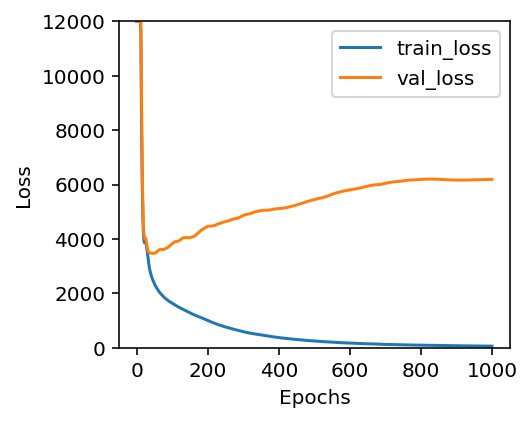

In [12]:
ncols = X.shape[1]
n_neurons = 100
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.Tanh(),
    nn.Linear(n_neurons, 1)
)

history = train1(model, X_train, X_test, y_train, y_test,
                 learning_rate=.1, nepochs=1000)

plot_history(torch.clamp(history, 0, 12000))

### Use weight decay to reduce overfitting

In [13]:
def train2(model, X_train, X_test, y_train, y_test,
           learning_rate = .5, nepochs=2000, weight_decay=0, trace=True):
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, weight_decay=weight_decay)
    history = [] # track training and validation loss
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if trace and epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    return torch.tensor(history)

In [ ]:
ncols = X.shape[1]
n_neurons = 100

fig, axes = plt.subplots(1, 4,figsize=(12,2.5))

for wd,ax in zip([0,.2,.4,1],axes):
    model = nn.Sequential(
        nn.Linear(ncols, n_neurons),
        nn.Tanh(),
        nn.Linear(n_neurons, 1)
    )
    history = train2(model, X_train, X_test, y_train, y_test,
                     learning_rate=.1, nepochs=1000, weight_decay=.2,
                     trace=False)
    ax.set_title(f"{n_neurons} neurons, wd={wd:.1f}")
    plot_history(torch.clamp(history, 0, 10000), ax=ax, maxy=10_000)

plt.tight_layout()
plt.show()

### Track best loss, model; crank up neurons and stop early

In [15]:
def train(model, X_train, X_test, y_train, y_test,
          learning_rate = .5, nepochs=2000, weight_decay=0):
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, weight_decay=weight_decay)
    history = [] # track training and validation loss
    best_loss = 1e10
    best_model = None
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"BEST MSE test loss {best_loss:.3f}")
    return torch.tensor(history), best_model

Epoch    0 MSE train loss    28496.822   test loss    31599.654
Epoch  100 MSE train loss    20004.242   test loss    20724.221
Epoch  200 MSE train loss     8493.885   test loss     8655.998
Epoch  300 MSE train loss     3431.249   test loss     3691.712
Epoch  400 MSE train loss     2832.068   test loss     3261.208
Epoch  500 MSE train loss     2745.890   test loss     3288.251
Epoch  600 MSE train loss     2659.319   test loss     3312.851
Epoch  700 MSE train loss     2576.820   test loss     3338.459
Epoch  800 MSE train loss     2495.859   test loss     3366.161
Epoch  900 MSE train loss     2414.241   test loss     3403.401
Epoch 1000 MSE train loss     2333.820   test loss     3453.582
BEST MSE test loss 3260.844
MSE test loss 3260.844


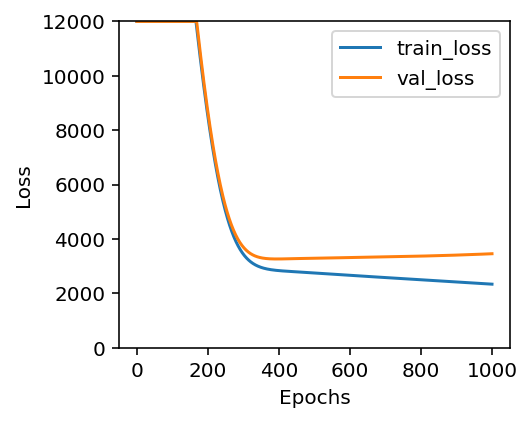

In [16]:
ncols = X.shape[1]
n_neurons = 1000
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.Tanh(),
    nn.Linear(n_neurons, 1)
)

history, best_model = train(model, X_train, X_test, y_train, y_test,
                            learning_rate=.001, nepochs=1000,
                            weight_decay=0)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)
print(f"MSE test loss {loss_test:.3f}")

plot_history(torch.clamp(history, 0, 12000))